### Student Information
Name: 蔡木風

Student ID: 113062628

GitHub ID: Arya0309

Kaggle name: Chua_Arya

Kaggle private scoreboard snapshot:

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

# 1. Enviroment build

In [17]:
import torch
import random

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


balance = False
val = False  # Split validation of not
val_size = 0.1
lr = 2e-5
batch_size = 64
epochs = 8
warmup_proportion = 0.1
patience = 3
grad_clip = 1.0
lora = False
weighted_loss = False
model_name = "FacebookAI/roberta-large"

# 2. Data prepare

In [18]:
import pandas as pd
import os

data_path = "dataset/"
df_data = pd.read_json(os.path.join(data_path, "tweets_DM.json"), lines=True)
df_data["_source"][0]

{'tweet': {'hashtags': ['Snapchat'],
  'tweet_id': '0x376b20',
  'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>'}}

In [19]:
df_data.head()

,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets


In [20]:
df_source = pd.json_normalize(df_data["_source"])

In [21]:
df_source.head()

,tweet.hashtags,tweet.tweet_id,tweet.text
0,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k..."
3,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,[],0x2de201,"""Trust is not the same as faith. A friend is s..."


In [22]:
df_data = pd.concat([df_data, df_source], axis=1)
df_data = df_data.drop(columns=["_source"])

In [23]:
df_data.head()

,_score,_index,_crawldate,_type,tweet.hashtags,tweet.tweet_id,tweet.text
0,391,hashtag_tweets,2015-05-23 11:42:47,tweets,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,433,hashtag_tweets,2016-01-28 04:52:09,tweets,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,232,hashtag_tweets,2017-12-25 04:39:20,tweets,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k..."
3,376,hashtag_tweets,2016-01-24 23:53:05,tweets,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,989,hashtag_tweets,2016-01-08 17:18:59,tweets,[],0x2de201,"""Trust is not the same as faith. A friend is s..."


In [24]:
df_data = df_data.rename(columns={"tweet.tweet_id": "tweet_id"})
df_data = df_data.rename(columns={"tweet.text": "text"})
df_data = df_data.rename(columns={"_score": "score"})
df_data.drop(
    columns={"_type", "tweet.hashtags", "_index", "_crawldate"},
    inplace=True,
)

In [25]:
df_data.head()

,score,tweet_id,text
0,391,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,433,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,232,0x28b412,"Confident of your obedience, I write to you, k..."
3,376,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,989,0x2de201,"""Trust is not the same as faith. A friend is s..."


In [26]:
df_identification = pd.read_csv(os.path.join(data_path, "data_identification.csv"))

In [27]:
df_data = pd.merge(df_data, df_identification, on="tweet_id")

In [28]:
df_data.head()

,score,tweet_id,text,identification
0,391,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train
1,433,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train
2,232,0x28b412,"Confident of your obedience, I write to you, k...",test
3,376,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train
4,989,0x2de201,"""Trust is not the same as faith. A friend is s...",test


In [29]:
df_test = df_data[df_data["identification"] == "test"]

In [30]:
df_emotion = pd.read_csv(os.path.join(data_path, "emotion.csv"))

In [31]:
df_emotion.head()

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation


In [32]:
df_data = pd.merge(df_data, df_emotion, on="tweet_id")

In [33]:
df_data.head()

,score,tweet_id,text,identification,emotion
0,391,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,433,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,376,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
3,120,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,train,joy
4,1021,0x2c91a8,Still waiting on those supplies Liscus. <LH>,train,anticipation


In [34]:
df_train = df_data[df_data["identification"] == "train"]

In [35]:
df_train.head()

,score,tweet_id,text,identification,emotion
0,391,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,433,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,376,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
3,120,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,train,joy
4,1021,0x2c91a8,Still waiting on those supplies Liscus. <LH>,train,anticipation


In [36]:
df_test.head()

,score,tweet_id,text,identification
2,232,0x28b412,"Confident of your obedience, I write to you, k...",test
4,989,0x2de201,"""Trust is not the same as faith. A friend is s...",test
9,66,0x218443,When do you have enough ? When are you satisfi...,test
30,104,0x2939d5,"God woke you up, now chase the day #GodsPlan #...",test
33,310,0x26289a,"In these tough times, who do YOU turn to as yo...",test


In [37]:
len(df_test)

411972

In [38]:
df_test.reset_index(drop=True, inplace=True)
len(df_test)

411972

# 3. Data preprocess

In [39]:
df_train["text"].duplicated().sum()

np.int64(3785)

In [40]:
df_train.drop_duplicates(subset="text", keep="first", inplace=True)

In [41]:
df_train["text"].duplicated().sum()

np.int64(0)

In [42]:
import matplotlib.pyplot as plt


def plot_distribution(df, column="emotion"):
    datas = df.groupby(column).size()
    ax = datas.plot(kind="bar", legend=False)

    for p in ax.patches:
        ax.annotate(
            f"{p.get_height()}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 5),
            textcoords="offset points",
        )

    plt.show()

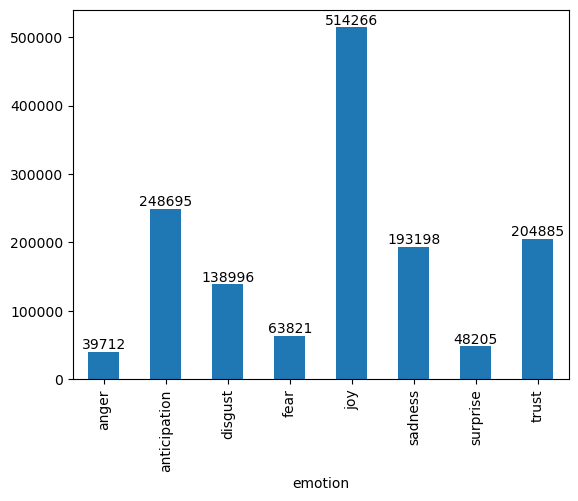

In [43]:
plot_distribution(df_train)

In [44]:
if val:  # Split validation if needed
    df_val = df_train.sample(frac=val_size, random_state=seed)
    df_train = df_train.drop(df_val.index)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)

In [45]:
# df_train = df_train[df_train["emotion"] != "joy"]

## Data balancing

In [46]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

if balance:
    X = df_train["text"]
    y = df_train["emotion"]

    upper_bound = 300000
    lower_bound = 0

    oversample_strategy = {}
    for label in y.unique():
        current_count = (y == label).sum()
        if current_count < lower_bound:
            oversample_strategy[label] = lower_bound
        else:
            oversample_strategy[label] = current_count

    oversampler = RandomOverSampler(
        sampling_strategy=oversample_strategy, random_state=seed
    )
    X_oversampled, y_oversampled = oversampler.fit_resample(X.to_frame(), y)

    df_oversampled = pd.concat([X_oversampled, y_oversampled], axis=1)
    df_oversampled.columns = ["text", "emotion"]

    undersample_strategy = {}
    for label in df_oversampled["emotion"].unique():
        current_count = (df_oversampled["emotion"] == label).sum()
        if current_count > upper_bound:
            undersample_strategy[label] = 96971
        else:
            undersample_strategy[label] = current_count

    undersampler = RandomUnderSampler(
        sampling_strategy=undersample_strategy, random_state=seed
    )
    X_balanced, y_balanced = undersampler.fit_resample(
        df_oversampled[["text"]], df_oversampled["emotion"]
    )

    # Step 4: Create the final resampled DataFrame
    df_balanced = pd.concat([X_balanced, y_balanced], axis=1)
    df_balanced.columns = ["text", "emotion"]

    # Step 5: Verify the new distribution
    print(df_balanced["emotion"].value_counts())

In [47]:
if balance:
    df_train = df_balanced
    plot_distribution(df_train)

In [48]:
df_sample = df_train.groupby("emotion", group_keys=False).apply(lambda x: x.sample(n=7))

/tmp/ipykernel_3447/645112662.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_train.groupby("emotion", group_keys=False).apply(lambda x: x.sample(n=7))


In [49]:
# sample = []
# for emotion in df_sample["emotion"].unique():
#     sample.append(
#         {
#             f"{emotion}": df_sample[df_sample["emotion"] == emotion][
#                 ["text", "emotion"]
#             ].to_dict(orient="records")
#         }
#     )
# sample = sample[0]

In [50]:
# sample["anger"]

In [51]:
print(df_train["text"].apply(type).value_counts())

text
<class 'str'>    1451778
Name: count, dtype: int64


In [52]:
import pandas as pd
import re


def clean_text(text):
    text = re.sub(r"http\S+", "<url>", text)
    text = re.sub(
        r"(?:https?://|www\.|:?//|:?//)[\w-]+[\.|/|\?][\w./?=&%#-]+", "<url>", text
    )
    text = re.sub(r"[\w-]+\.com(?:\b|/)", "<url>", text)
    text = re.sub(r"@\S+", "<user>", text)
    # text = re.sub(r"(<LH>\s*)+", "<LH>", text)
    text = text.replace("<LH>", "<mask>")
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"([!?.,;:])\1+", r"\1", text)
    return text


df_train["text"] = df_train["text"].astype(str).apply(clean_text)
if val:
    df_val["text"] = df_val["text"].astype(str).apply(clean_text)
df_test["text"] = df_test["text"].astype(str).apply(clean_text)

In [53]:
print(df_train["text"].apply(type).value_counts())

text
<class 'str'>    1451778
Name: count, dtype: int64


In [54]:
nan_rows = df_train[df_train["text"].isna()]
print("Rows with NaN values:")
print(nan_rows)

empty_rows = df_train[df_train["text"].str.strip() == ""]
print("Rows with empty text:")
print(empty_rows)

Rows with NaN values:
Empty DataFrame
Columns: [score, tweet_id, text, identification, emotion]
Index: []
Rows with empty text:
Empty DataFrame
Columns: [score, tweet_id, text, identification, emotion]
Index: []


In [55]:
df_train = df_train.dropna(subset=["text"])
if val:
    df_val = df_val.dropna(subset=["text"])
df_test = df_test.dropna(subset=["text"])

df_train = df_train[df_train["text"].str.strip() != ""]
if val:
    df_val = df_val[df_val["text"].str.strip() != ""]
df_test = df_test[df_test["text"].str.strip() != ""]

In [56]:
nan_rows = df_train[df_train["text"].isna()]
print("Rows with NaN values:")
print(nan_rows)

empty_rows = df_train[df_train["text"].str.strip() == ""]
print("Rows with empty text:")
print(empty_rows)

Rows with NaN values:
Empty DataFrame
Columns: [score, tweet_id, text, identification, emotion]
Index: []
Rows with empty text:
Empty DataFrame
Columns: [score, tweet_id, text, identification, emotion]
Index: []


In [57]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(df_train["emotion"])

df_train["label"] = le.transform(df_train["emotion"])
if val:
    df_val["label"] = le.transform(df_val["emotion"])

In [58]:
df_train.to_csv(os.path.join(data_path, "train.csv"))
if val:
    df_val.to_csv(os.path.join(data_path, "val.csv"))
df_test.to_csv(os.path.join(data_path, "test.csv"))

# 4. Training

In [59]:
import pandas as pd
import os
import torch


data_path = "dataset/"
df_train = pd.read_csv(os.path.join(data_path, "train.csv"))
df_val = pd.read_csv(os.path.join(data_path, "val.csv"))
df_test = pd.read_csv(os.path.join(data_path, "test.csv"))

In [60]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType

temp_model_name = "FacebookAI/roberta-large"

if temp_model_name == model_name:
    pass
else:
    model_name = temp_model_name
    raise ValueError(
        "Model name mismatch, if you intended to change the model name, please rerun the cell"
    )

tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir="cache/")

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(df_train["label"].unique()),
    cache_dir="cache/",
    ignore_mismatched_sizes=True,
)


if lora:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        task_type=TaskType.SEQ_CLS,
    )
    model = get_peft_model(model, lora_config)

    for name, param in model.named_parameters():
        if "lora" not in name:
            param.requires_grad = False

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define the new special tokens
special_tokens = {"additional_special_tokens": ["<url>", "<user>"]}

# Add the special tokens to the tokenizer
tokenizer.add_special_tokens(special_tokens)

# Verify the new tokens
print("Added tokens:", tokenizer.additional_special_tokens)

In [ ]:
model.resize_token_embeddings(len(tokenizer))

In [61]:
from torch.utils.data import Dataset, DataLoader


class EmotionDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.text = df["text"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        item = {"text": self.text[idx], "label": self.labels[idx]}
        return item

In [62]:
def collate_fn(batch):
    inputs = tokenizer(
        [x["text"] for x in batch],
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt",
    )
    inputs = inputs.to(device)
    labels = torch.tensor([x["label"] for x in batch], dtype=torch.long)
    labels = labels.to(device)
    return inputs, labels

In [63]:
import torch


class EmotionClassifier(torch.nn.Module):
    def __init__(self, model, num_emotions=8):
        super(EmotionClassifier, self).__init__()
        self.model = model
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, num_emotions)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        logits = self.dropout(logits)

        return logits

In [9]:
train_dataset = EmotionDataset(df_train)
dl_train = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)

if val:
    validation_dataset = EmotionDataset(df_val)
    dl_validation = DataLoader(
        validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
    )

In [ ]:
for batch in dl_train:
    print(batch)
    break

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Calculate the cross entropy loss for each instance
        ce_loss = F.cross_entropy(inputs, targets, reduction="none")

        # Compute the probability of the correct class (ground truth)
        pt = torch.exp(-ce_loss)

        # Focal Loss computation
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

In [64]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionClassifier(model).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

if lora:
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Original total parameters: {total_params}")
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters after LoRA: {trainable_params}")

if weighted_loss:
    alpha = 0.5
    gamma = 2
    loss_fn = FocalLoss(alpha=alpha, gamma=gamma).to(device)
else:
    loss_fn = CrossEntropyLoss().to(device)

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassPrecision,
    MulticlassRecall,
)

# Initialize metrics (update num_classes based on your dataset)
num_classes = len(
    df_train["label"].unique()
)  # Replace with the number of emotion classes
accuracy = MulticlassAccuracy(num_classes=num_classes).to(device)
f1_score = MulticlassF1Score(num_classes=num_classes).to(device)
precision = MulticlassPrecision(num_classes=num_classes).to(device)
recall = MulticlassRecall(num_classes=num_classes).to(device)

# Set up optimizer and learning rate scheduler with warm-up
total_steps = len(dl_train) * epochs
warmup_steps = int(warmup_proportion * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

# Lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

train_steps = []  # Keeps track of steps for plotting
val_steps = []  # Keeps track of validation steps for plotting

step = 0
step_val = 0
best_f1_score = 0.0  # Initialize to keep track of the best validation F1 score

for epoch in range(epochs):
    model.train()
    total_loss = 0
    pbar = tqdm(dl_train, desc=f"Epoch {epoch + 1}")
    i = 0
    for batch in pbar:
        # Extract inputs and labels from batch
        inputs, labels = batch

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        # Update metrics
        predictions = torch.argmax(outputs, dim=-1)
        accuracy.update(predictions, labels)
        f1_score.update(predictions, labels)
        precision.update(predictions, labels)
        recall.update(predictions, labels)

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        # Update learning rate scheduler
        scheduler.step()

        if step % 5000 == 0:
            train_steps.append(step)
            train_losses.append(loss.item())
            train_accuracies.append(accuracy.compute().item())
            train_f1_scores.append(f1_score.compute().item())

        # Display progress
        pbar.set_postfix({"loss": total_loss / (i + 1)})

        step += 1
        i += 1

    print(f"Training loss: {total_loss / len(dl_train)}")
    print(f"Training Accuracy: {train_accuracies[-1]}")
    print(f"Training F1 Score: {train_f1_scores[-1]}")
    print(f"Training Precision: {precision.compute().item()}")
    print(f"Training Recall: {recall.compute().item()}")

    # Reset metrics for next epoch
    accuracy.reset()
    f1_score.reset()
    precision.reset()
    recall.reset()

    torch.save(model, f"model/model_epoch_{epoch+1}.ckpt")

    if val:
        # Validation phase
        model.eval()
        total_loss = 0
        pbar = tqdm(dl_validation, desc=f"Epoch {epoch + 1} Validation")
        with torch.no_grad():
            for batch in pbar:
                inputs, labels = batch

                outputs = model(**inputs)
                loss = loss_fn(outputs, labels)
                total_loss += loss.item()

                # Update metrics
                predictions = torch.argmax(outputs, dim=-1)
                accuracy.update(predictions, labels)
                f1_score.update(predictions, labels)
                precision.update(predictions, labels)
                recall.update(predictions, labels)

                if step_val % 5000 == 0:
                    val_steps.append(step_val / val_size)
                    val_losses.append(loss.item())
                    val_accuracies.append(accuracy.compute().item())
                    val_f1_scores.append(f1_score.compute().item())

                step_val += 1

        print(f"Validation loss: {total_loss / len(dl_validation)}")
        print(f"Validation Accuracy: {val_accuracies[-1]}")
        print(f"Validation F1 Score: {val_f1_scores[-1]}")
        print(f"Validation Precision: {precision.compute().item()}")
        print(f"Validation Recall: {recall.compute().item()}")

        # Early stopping mechanism
        if epoch == 0:
            best_loss = total_loss
            best_f1_score = val_f1_scores[-1]
            patience_counter = 0
        else:
            if total_loss < best_loss or val_f1_scores[-1] > best_f1_score:
                # Save model checkpoint if validation metrics improve
                best_loss = min(best_loss, total_loss)
                best_f1_score = max(best_f1_score, val_f1_scores[-1])
                patience_counter = 0
                torch.save(
                    {
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                    },
                    f"model/checkpoint{epoch+1}.pth",
                )
            else:
                patience_counter += 1
                if patience_counter == patience:
                    print("Early stopping")
                    break

        # Reset metrics for next epoch
        accuracy.reset()
        f1_score.reset()
        precision.reset()
        recall.reset()

In [ ]:
# Plotting the metrics
plt.figure(figsize=(14, 10))

# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.plot(train_steps, train_losses, label="Training Loss")
if val:
    plt.plot(val_steps, val_losses, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy and F1 score on the same chart
plt.subplot(2, 1, 2)
plt.plot(train_steps, train_accuracies, label="Training Accuracy", linestyle="-")
plt.plot(train_steps, train_f1_scores, label="Training F1 Score", linestyle="--")
if val:
    plt.plot(val_steps, val_accuracies, label="Validation Accuracy", linestyle="-")
    plt.plot(val_steps, val_f1_scores, label="Validation F1 Score", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Score")
plt.title("Training and Validation Accuracy & F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

#### Testing

In [65]:
load_model = "model/model_epoch_5_BFN.ckpt"

In [66]:
from torch.utils.data import Dataset


class TestEmotionDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.text = df["text"].tolist()
        self.id = df["tweet_id"].tolist()

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        item = {"text": self.text[idx], "id": self.id[idx]}
        return item


def collate_fn(batch):
    inputs = tokenizer(
        [x["text"] for x in batch], return_tensors="pt", padding=True, truncation=True
    )
    inputs = inputs.to(device)
    ids = [x["id"] for x in batch]
    return inputs, ids


test_dataset = TestEmotionDataset(df_test)
dl_test = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(load_model, map_location=device).to(device)

/tmp/ipykernel_3447/1013053347.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(load_model, map_location=device).to(device)


In [68]:
from tqdm import tqdm

model.eval()
with torch.no_grad():
    tweet_ids = []
    emotion = []
    pbar = tqdm(dl_test, desc="Predicting")
    for inputs, ids in pbar:
        logits = model(**inputs)
        preds = torch.argmax(logits, dim=1)
        tweet_ids.extend(ids)
        emotion.extend(preds.tolist())

Predicting: 100%|██████████| 12875/12875 [06:42<00:00, 32.01it/s]


In [69]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(df_train["emotion"])

emotion = le.inverse_transform(emotion)
submit = pd.DataFrame({"id": tweet_ids, "emotion": emotion})
submit.to_csv("submission.csv", index=False)

In [70]:
submit.head(10)

,id,emotion
0,0x28b412,anticipation
1,0x2de201,trust
2,0x218443,joy
3,0x2939d5,anticipation
4,0x26289a,anticipation
5,0x31c6e0,surprise
6,0x32edee,sadness
7,0x3714ee,anger
8,0x235628,joy
9,0x283024,sadness


# 5. Report

## Model

Below are the models I experimented with for fine-tuning:

1. **BERT-base-uncased**
2. **BERT-base-cased**
3. **BERT-large-uncased**
4. **ROBERTA-base**
5. **ROBERTA-large**
6. **twitter-roberta-base-emotion-multilabel-latest**
7. **cardiffnlp/twitter-roberta-base-sentiment-latest**
8. **T5-large** *(failed)*

Among these, **ROBERTA-large** yielded the best results in my experience.

### Parameter Setting

Due to the lengthy time required for fine-tuning, I couldn't perform detailed hyperparameter tuning. The final parameter settings were based on a combination of suggestions from GPT and my personal experience.

### Overfitting

Initially, I focused on mitigating overfitting during the fine-tuning process, assuming it was crucial for better performance. Techniques applied included:

- Learning rate scheduling
- Warm-up steps
- Weight decay
- Dropout layers

However, overfitting still consistently occurred around **epoch 5**. I concluded that, given the nature of the dataset, overfitting might be unavoidable despite these measures.

---

## Preprocessing

Deciding on how to clean the data presented the most challenges. The main options were whether to **delete**, **retain**, or **convert into special tokens**. Given the vast number of combinations, I initially considered sampling to test performance. However, since analyzing only a portion of the data could introduce additional confounding factors, I adopted a decision-tree approach to refine choices iteratively until reaching the optimal setup.

### Preprocessing Steps

1. **Delete duplicates**
2. **Remove empty entries**
3. **Convert URLs into `<url>` tokens**
4. **Convert `<LH>` into `<mask>` tokens**
5. **Convert usernames into `<user>` tokens**
6. **Reduce multiple punctuation marks to a single one**
7. **Reduce multiple spaces to a single space**

### Mask Token

Replacing the `<LH>` token with `<mask>` initially seemed counterintuitive since the model was being used for sequence classification rather than fill-mask tasks. However, I hypothesized that since the original model was trained with `<mask>` tokens, this approach might reduce noise. Surprisingly, this change improved performance by about **1%**.

Later, I discovered that the `<LH>` token functions as a cloze-style placeholder. Toward the end of my experimentation, I attempted to use a Twitter fine-tuned BERT-large fill-mask model to reconstruct the missing parts, but time constraints prevented me from completing the fine-tuning process or conducting deeper analyses. This aspect requires further exploration.

### Special Tokens

Initially, I removed URLs and usernames, considering them noise. However, upon analyzing the preprocessed dataset, I observed that deleting these elements made the sentences semantically awkward. Retaining and replacing these elements with special tokens resulted in a noticeable improvement in the final scores, confirming their relevance to the task.

---

## Balancing

The training dataset provided is extremely unbalanced, with the "joy" class containing about 40% of the total dataset. To address this issue, I experimented with several methods:

### SMOTE

The first approach I tried was **SMOTE (Synthetic Minority Oversampling Technique)** to generate additional data and balance the dataset. However, this method was extremely time-consuming, and I was uncertain whether SMOTE could effectively work with BERT-like embeddings. 

### Undersampling and Oversampling

1. **Simple Undersampling and Oversampling**  
   I attempted to balance the dataset by:
   - **Undersampling:** Reducing the size of overrepresented classes.
   - **Oversampling:** Duplicating instances in underrepresented classes.  

   Unfortunately, this resulted in significant performance degradation. The duplicated data led to overfitting, and the model performance dropped sharply.

2. **Partial Undersampling of the "joy" Class**  
   I tried reducing the "joy" class to 60% of its original size to make the dataset more balanced. However, this also caused a performance downgrade.

### Ollama Oversampling

Another method I explored was using **LLaMA** to generate synthetic data for underrepresented classes. However:
- Generating sufficient data for each class (excluding "joy") required approximately 20 hours per class.
- The randomness in model generation led to some unexpected and irrelevant outputs.
- My past experiences with generative models in competitions (e.g., AI-CUP) created skepticism about the reliability of this approach.

Due to these issues, I found this method to be impractical.

### Training-Level Balancing - Weighted Loss

#### 1. Multilevel Weighted Loss  
   I assigned weights to the loss function by multiplying the loss for each class with its relative size fraction.  
   **Outcome:** This method significantly downgraded performance, likely due to improper weight balancing.

#### 2. Focal Loss  
   Focal loss is designed to address imbalanced datasets by focusing more on hard-to-classify examples. While it slightly decreased performance overall, it provided the following benefits:
   - Better synchronization between F1 score and loss.
   - Reduced overfitting. (Without focal loss, the highest F1 score often coincided with the early stages of overfitting.)

### Conclusion

Despite the severe class imbalance in the dataset, none of the balancing methods tested yielded significant performance improvements. The optimal model I ultimately used did not apply any balancing techniques.  

Further exploration into advanced data augmentation or novel loss functions might be needed to effectively address this challenge.

---

## Others

### PCA and t-SNE Analysis

To better understand the embeddings, I experimented with **PCA** and **t-SNE** visualizations. These methods provided insights into the data distribution and class separability. However, I avoided including this analysis in the main codebase as it would unnecessarily complicate the implementation. It remained an exploratory step for understanding the data and model behavior.

### Mask Handling

When working with `<mask>` tokens in the dataset, I identified some improvements that could potentially enhance the quality of the data and model performance:

1. **Cleaning Excessive `<mask>` Tokens**  
   - In the training dataset, some examples contained an excessive number of `<mask>` tokens, with the highest being up to 18.  
   - Removing such examples could make the dataset cleaner and less noisy.

2. **Improving the Mask Filling Strategy**  
   - **Current Approach:**  
     - Fill `<mask>` tokens one by one with the highest-scoring prediction, regardless of the score.  
     - This approach may introduce low-confidence predictions into the data.  
   - **Proposed Enhancement:**  
     - Only fill `<mask>` tokens if the model's confidence score exceeds a threshold (e.g., 0.7).  
     - This would ensure higher-quality and more reliable mask replacements.  
   
3. **Appended Emotion Tags**  
   - During the training data filling process, I appended the corresponding emotion to the end of each text in the format:  
     `(emotion: {emotion})`.  
   - While attention mechanisms work in complex and sometimes unintuitive ways, testing revealed that this modification made the mask-filling process slightly more stable.